# Preprocessing

In [1]:
import os
import re
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import librosa.display

# Define bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Define the function to process audio files with a duration limit
def process_audio(file_path, lowcut=300.0, highcut=3400.0, target_sr=16000, 
                  window_size=0.025, window_stride=0.01, max_duration=30):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)
        print(f"Original Sampling Rate: {sr}, Duration: {len(y) / sr:.2f} seconds")

        # Trim audio to the first max_duration seconds
        max_samples = int(max_duration * sr)
        y = y[:max_samples]

        # Resample to the target sampling rate
        resampled_signal = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

        # Apply bandpass filtering
        filtered_signal = bandpass_filter(resampled_signal, lowcut, highcut, target_sr)

        # Normalize the audio signal (replace any non-numeric values)
        normalized_signal = np.nan_to_num(filtered_signal, nan=0.0, posinf=0.0, neginf=0.0)

        # Windowing
        frame_length = int(window_size * target_sr)  # Number of samples per frame
        frame_step = int(window_stride * target_sr)  # Number of samples per stride
        windows = librosa.util.frame(normalized_signal, frame_length=frame_length, hop_length=frame_step).T

        print(f"Processed Signal: {windows.shape[0]} frames of size {frame_length}")
        return windows
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Directory containing the audio files
audio_directory = r"E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio"

pattern1 = re.compile(r"^HW(\d+)_Q(\d+)_(\d{9})_(male|female)\.mp3$", re.IGNORECASE)
pattern2 = re.compile(r"^HW(\d+)_intro_(\d{9})_(male|female)\.mp3$", re.IGNORECASE)

patterns = [pattern1, pattern2]

# We will store all files in dictionaries by student ID
#   { student_id: [list_of_file_paths], ... }
male_files_by_id = {}
female_files_by_id = {}

# Collect all mp3 files that match our patterns
for file in os.listdir(audio_directory):
    if not file.lower().endswith('.mp3'):
        continue
    file_path = os.path.join(audio_directory, file)
    
    matched = False
    for pattern in patterns:
        match = pattern.match(file)
        if match:
            # Identify which pattern matched
            if pattern == pattern1:
                student_id = match.group(3)  # 9-digit ID from pattern1
                gender = match.group(4).lower()
            else:
                student_id = match.group(2)  # 9-digit ID from pattern2
                gender = match.group(3).lower()

            # Add file to male or female dict
            if gender == 'male':
                male_files_by_id.setdefault(student_id, []).append(file_path)
            else:
                female_files_by_id.setdefault(student_id, []).append(file_path)
            
            matched = True
            break
    
    # If not matched, it's outside the naming convention, so ignore it
    if not matched:
        pass

# Now we have all male and female files grouped by ID.
# We want exactly 6 distinct people total: 5 male IDs and 5 female IDs.
# For demonstration, we'll just pick the first 3 keys from each dictionary.
# You can adapt the selection logic as you prefer.

male_ids = sorted(male_files_by_id.keys())
female_ids = sorted(female_files_by_id.keys())

# Ensure we have at least 5. If not, handle appropriately.
if len(male_ids) < 5 or len(female_ids) < 5:
    raise ValueError("Not enough male/female student IDs in your dataset to pick 3 of each.")

# Pick the first 3 (or however you choose them)
selected_male_ids = male_ids[:5]
selected_female_ids = female_ids[:5]

print(f"Selected Male IDs: {selected_male_ids}")
print(f"Selected Female IDs: {selected_female_ids}")

# Gather all files for these 6 selected IDs
balanced_files = []
for sid in selected_male_ids:
    balanced_files.extend(male_files_by_id[sid])

for sid in selected_female_ids:
    balanced_files.extend(female_files_by_id[sid])

print(f"Total files from the 10 selected IDs: {len(balanced_files)}")

# Process the final_file_list
processed_data = []
for file_path in balanced_files:
    print(f"Processing: {file_path}")
    processed = process_audio(file_path)
    if processed is not None:
        processed_data.append(processed)

print(f"Processed {len(processed_data)} files successfully.")

Selected Male IDs: ['151501033', '159403005', '610300017', '610300032', '610399182']
Selected Female IDs: ['610300070', '810100075', '810100135', '810100168', '810100193']
Total files from the 10 selected IDs: 68
Processing: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_intro_151501033_male.mp3
Original Sampling Rate: 44100, Duration: 14.88 seconds
Processed Signal: 1486 frames of size 400
Processing: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q1_151501033_male.mp3
Original Sampling Rate: 44100, Duration: 171.92 seconds
Processed Signal: 2998 frames of size 400
Processing: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q2_151501033_male.mp3
Original Sampling Rate: 44100, Duration: 294.34 seconds
Processed Signal: 2998 frames of size 400
Processing: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q3_151501033_male.mp3
Original Sampling Rate: 44100, Duration: 215.81 seconds
Processed S

# feature extraction

In [2]:
import os
import librosa
import numpy as np
import json
from collections import Counter

#########################################
#      HELPER: Extract Student ID       #
#########################################
def extract_student_id(file_name):
    """
    Parses the student ID from a filename of the form:
      HW<number>_Q<number>_<9-digit-id>_male.mp3
      HW<number>_intro_<9-digit-id>_female.mp3
    or something similar, where the 9-digit ID is
    the third underscore-delimited part.
    """
    parts = file_name.split('_')
    if len(parts) < 3:
        # Not enough underscores to safely extract
        return "unknown"
    return parts[2]  # The ID is typically the third part

#########################################
#        Extract Features       #
#########################################
def extract_features(audio_data, sr):
    """
    Extracts various audio features using librosa:
      - Log-Mel Spectrogram
      - MFCC (13 coefficients)
      - Spectral Centroid / Bandwidth / Contrast
      - Zero-Crossing Rate
      - Energy (RMS)
    
    Returns a dictionary of lists (JSON-serializable).
    """
    try:
        # 1) Mel Spectrogram --> Log-Mel
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_data, sr=sr, n_mels=128, fmax=8000
        )
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # 2) MFCC (13 Coefficients)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

        # 3) Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # 4) Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)

        # 5) Energy (RMS)
        energy = librosa.feature.rms(y=audio_data)

        features = {
            "Log-Mel Spectrogram": log_mel_spectrogram.tolist(),
            "MFCC": mfccs.tolist(),
            "Spectral Centroid": spectral_centroid.tolist(),
            "Spectral Bandwidth": spectral_bandwidth.tolist(),
            "Spectral Contrast": spectral_contrast.tolist(),
            "Zero-Crossing Rate": zero_crossing_rate.tolist(),
            "Energy": energy.tolist()
        }
        return features

    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

#########################################
      #  MAIN EXTRACTION LOOP  #
#########################################
# Make sure 'processed_data' and 'balanced_files' come from your
# preprocessing code, and they are the same length & order.

if len(processed_data) != len(balanced_files):
    raise ValueError("Mismatch between processed_data and balanced_files. Ensure they are aligned.")

features_data = []
for idx, processed_audio in enumerate(processed_data):
    try:
        # Flatten if it is a 2D array of frames
        if isinstance(processed_audio, np.ndarray) and processed_audio.ndim > 1:
            audio_data = processed_audio.flatten()
        else:
            audio_data = processed_audio

        current_file = balanced_files[idx]
        print(f"Extracting features for file {idx + 1}: {current_file}")

        # Simple gender label logic based on filename
        file_name = os.path.basename(current_file).lower()
        if "female" in file_name:
            label = "female"
        elif "male" in file_name:
            label = "male"
        else:
            label = "unknown"  # Neither "male" nor "female" in filename

        print(f"Assigned label: {label}")

        # Actual feature extraction
        features = extract_features(audio_data, sr=16000)
        if features:
            student_id = extract_student_id(file_name)
            features_data.append({
                "file": current_file,
                "label": label,
                "student_id": student_id,
                "features": features
            })

    except Exception as e:
        print(f"Error extracting features for file {current_file}: {e}")

# Save extracted features to JSON
output_file = "extracted_features_dataset.json"
with open(output_file, "w") as f:
    # Use an indent for readability
    json.dump(features_data, f, indent=4)

# Debugging: Check how many male vs. female
binary_labels = [1 if entry['label'] == "male" else 0 for entry in features_data]
print(f"Class distribution (1=male,0=female/unknown): {Counter(binary_labels)}")

print(f"Extracted features for {len(features_data)} files successfully.")
print(f"Features saved to {output_file}")


Extracting features for file 1: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_intro_151501033_male.mp3
Assigned label: male
Extracting features for file 2: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q1_151501033_male.mp3
Assigned label: male
Extracting features for file 3: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q2_151501033_male.mp3
Assigned label: male
Extracting features for file 4: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q3_151501033_male.mp3
Assigned label: male
Extracting features for file 5: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q4_151501033_male.mp3
Assigned label: male
Extracting features for file 6: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q5_151501033_male.mp3
Assigned label: male
Extracting features for file 7: E:\C\University\Semesters\Semester 7\Machine Learning\Project\Audio\HW1_Q6_15150103

# Logistic Regression

Class distribution: Counter({np.int64(0): 7, np.int64(1): 7, np.int64(2): 7, np.int64(3): 7, np.int64(5): 7, np.int64(4): 7, np.int64(7): 7, np.int64(8): 7, np.int64(6): 6, np.int64(9): 6})
Class distribution after filtering: Counter({np.int64(0): 7, np.int64(1): 7, np.int64(2): 7, np.int64(3): 7, np.int64(5): 7, np.int64(4): 7, np.int64(7): 7, np.int64(8): 7, np.int64(6): 6, np.int64(9): 6})
Model Accuracy: 0.8235
Classification Report:
              precision    recall  f1-score   support

   151501033       1.00      1.00      1.00         3
   159403005       1.00      1.00      1.00         3
   610300017       1.00      0.75      0.86         4
   610300032       1.00      0.75      0.86         4
   610300070       1.00      1.00      1.00         4
   610399182       1.00      1.00      1.00         3
   810100075       0.60      1.00      0.75         3
   810100135       0.60      0.75      0.67         4
   810100168       0.50      0.33      0.40         3
   810100193     

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


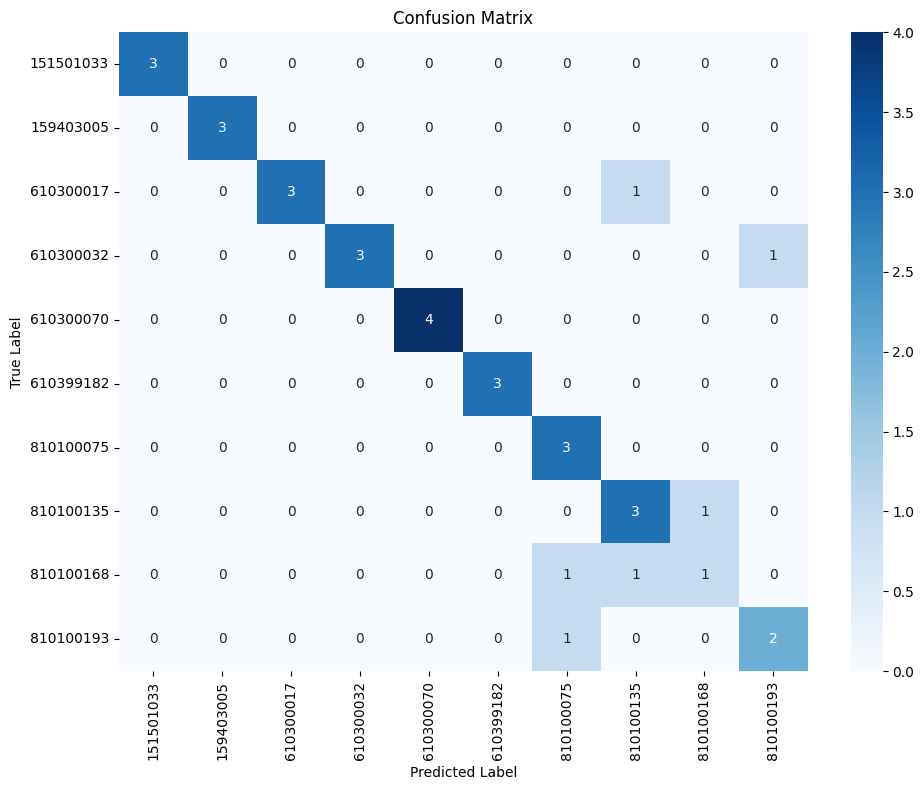

In [3]:
import json
import numpy as np
from collections import Counter
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 1) Load extracted features from JSON file
# ------------------------------------------------
input_file = "extracted_features_dataset.json"
with open(input_file, "r") as f:
    features_data = json.load(f)

# ------------------------------------------------
# 2) Build X and Y from the JSON
#    - X: numeric feature vectors
#    - Y: student_id (speaker) labels
# ------------------------------------------------
X = []  # Features
Y = []  # Labels (student IDs)

for entry in features_data:
    student_id = entry["student_id"]
    features = entry["features"]
    
    # Flatten each feature array by taking the mean across time (axis=1).
    feature_vector = []
    for feat_name, feat_array in features.items():
        # feat_array is typically shape (num_features, num_frames)
        # Taking mean over axis=1 yields shape (num_features,)
        feature_vector.extend(np.mean(feat_array, axis=1))
    
    X.append(feature_vector)
    Y.append(student_id)

X = np.array(X)
Y = np.array(Y)

# ------------------------------------------------
# 3) Encode student IDs into numeric classes
# ------------------------------------------------
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

class_counts = Counter(Y_encoded)
print("Class distribution:", class_counts)

# ------------------------------------------------
# 4) Optional: Only keep classes that have >=2 samples
# ------------------------------------------------
valid_classes = [cls for cls, count in class_counts.items() if count > 1]

X_filtered = [X[i] for i in range(len(X)) if Y_encoded[i] in valid_classes]
Y_filtered = [Y_encoded[i] for i in range(len(Y_encoded)) if Y_encoded[i] in valid_classes]

X_filtered = np.array(X_filtered)
Y_filtered = np.array(Y_filtered)

class_counts_filtered = Counter(Y_filtered)
print("Class distribution after filtering:", class_counts_filtered)

# ------------------------------------------------
# 5) Scale/normalize features
# ------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# ------------------------------------------------
# 6) Train-test split
#    - Example: 50% test, with stratified sampling
# ------------------------------------------------
min_test_size = ceil(len(set(Y_filtered)) / len(Y_filtered))
# test_size = max(0.25, min_test_size)  # if you want at least 25%

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_filtered, test_size=0.5, random_state=42, stratify=Y_filtered
)

# ------------------------------------------------
# 7) Train Logistic Regression
# ------------------------------------------------
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)

# ------------------------------------------------
# 8) Evaluate the model
# ------------------------------------------------
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
final_classes = np.unique(Y_filtered)
target_names = label_encoder.inverse_transform(final_classes)
print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# -------------------------------
# 9) Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# KNN

Model Accuracy: 0.5294
Classification Report:
              precision    recall  f1-score   support

   151501033       0.67      0.67      0.67         3
   159403005       0.67      0.67      0.67         3
   610300017       1.00      0.50      0.67         4
   610300032       1.00      0.75      0.86         4
   610300070       0.29      0.50      0.36         4
   610399182       1.00      1.00      1.00         3
   810100075       0.14      0.33      0.20         3
   810100135       0.67      0.50      0.57         4
   810100168       0.00      0.00      0.00         3
   810100193       0.50      0.33      0.40         3

    accuracy                           0.53        34
   macro avg       0.59      0.52      0.54        34
weighted avg       0.61      0.53      0.55        34



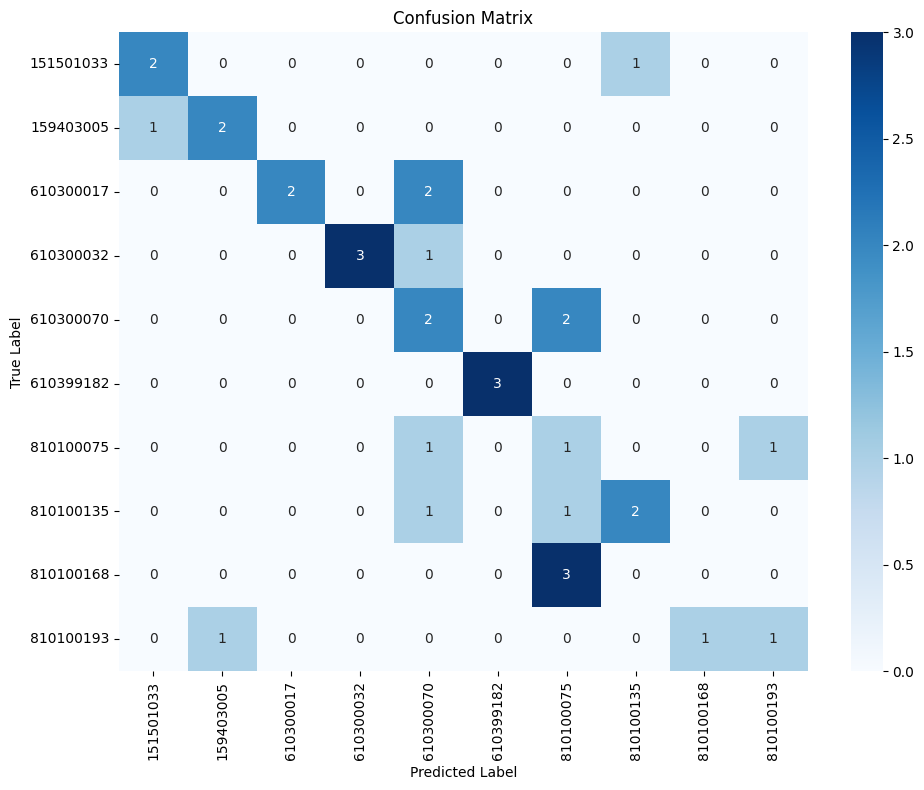

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# ---------------------------------------------------
# 1) Train KNN classifier
# ---------------------------------------------------
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# ---------------------------------------------------
# 2) Evaluate the model
# ---------------------------------------------------
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
final_classes = np.unique(Y_filtered)
target_names = label_encoder.inverse_transform(final_classes)
print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# ---------------------------------------------------
# 3) Plot Confusion Matrix
# ---------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# MLP

Model Accuracy: 0.7647
Classification Report:
              precision    recall  f1-score   support

   151501033       1.00      0.67      0.80         3
   159403005       1.00      0.67      0.80         3
   610300017       1.00      0.75      0.86         4
   610300032       1.00      0.75      0.86         4
   610300070       1.00      1.00      1.00         4
   610399182       0.75      1.00      0.86         3
   810100075       0.43      1.00      0.60         3
   810100135       0.75      0.75      0.75         4
   810100168       0.33      0.33      0.33         3
   810100193       1.00      0.67      0.80         3

    accuracy                           0.76        34
   macro avg       0.83      0.76      0.77        34
weighted avg       0.84      0.76      0.78        34



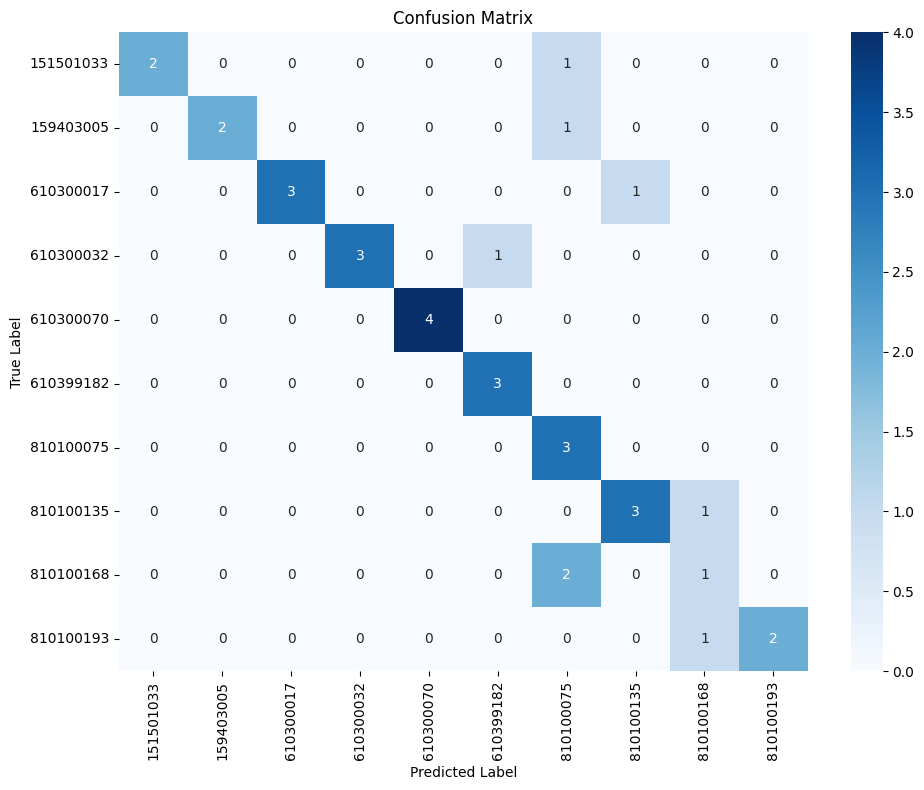

In [40]:
from sklearn.neural_network import MLPClassifier

# ------------------------------------------------
# 1) Train MLP classifier
# ------------------------------------------------
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# ------------------------------------------------
# 2) Evaluate the model
# ------------------------------------------------
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
final_classes = np.unique(Y_filtered)
target_names = label_encoder.inverse_transform(final_classes)
print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# ------------------------------------------------
# 3) Plot Confusion Matrix
# ------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# SVM

Model Accuracy: 0.5882
Classification Report:
              precision    recall  f1-score   support

   151501033       0.50      0.67      0.57         3
   159403005       0.67      0.67      0.67         3
   610300017       1.00      0.75      0.86         4
   610300032       1.00      0.75      0.86         4
   610300070       0.50      0.25      0.33         4
   610399182       0.75      1.00      0.86         3
   810100075       0.22      0.67      0.33         3
   810100135       0.67      0.50      0.57         4
   810100168       0.50      0.33      0.40         3
   810100193       1.00      0.33      0.50         3

    accuracy                           0.59        34
   macro avg       0.68      0.59      0.59        34
weighted avg       0.69      0.59      0.60        34



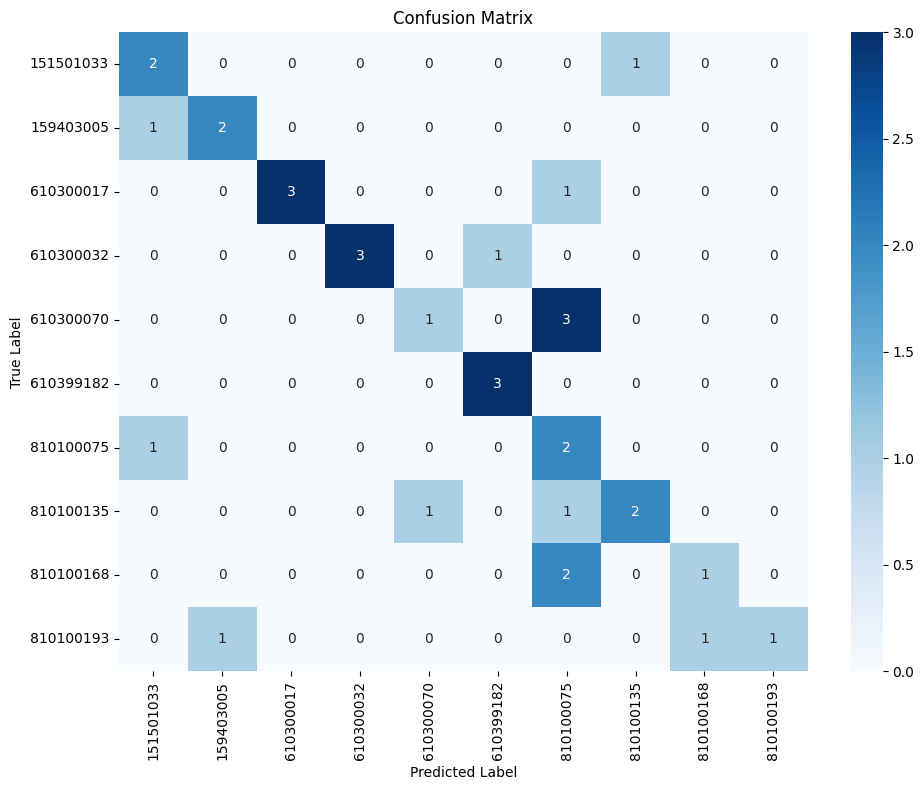

In [26]:
from sklearn.svm import SVC


# ------------------------------------------------
# 1) Train SVM classifier
# ------------------------------------------------
svm_clf = SVC(kernel='rbf', gamma='scale', C=2, random_state=42)
svm_clf.fit(X_train, y_train)

# ------------------------------------------------
# 2) Evaluate the model
# ------------------------------------------------
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
final_classes = np.unique(Y_filtered)
target_names = label_encoder.inverse_transform(final_classes)
print(classification_report(
    y_test,
    y_pred,
    labels=final_classes,
    target_names=target_names
))

# ------------------------------------------------
# 3) Plot Confusion Matrix
# ------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=final_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
